In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
from scipy.optimize import least_squares
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/pk9185/sipm-analysis/jupyter


Laser waveform is 4000 samples long (16us) while scintillation waveform is 5000 samples long (20us) in liq. 7. Need to extend the laser waveform.

In [3]:
# data folder
path = "/scratch/gpfs/GALBIATI/results/2023-12-13"
data_spe = {}
channels = np.arange(8)
volt = 98
for ch in channels:
    data_spe[ch] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
    files = glob.glob(f"{path}/*volt_{volt}*laser_waveform_liq5.h5")
    print(files)
    for f in files:
        df = pd.read_hdf(f, key=f'{volt}/{ch}')
        data_spe[ch]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
        if data_spe[ch]['time'].shape[0]==0:
            data_spe[ch]['time'] = np.array(df['time'])
        if np.array(df['n_spe_wfs'])[0]>0:
            if data_spe[ch]['avg_spe_wf'].shape[0]==0:
                data_spe[ch]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            else:
                data_spe[ch]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
    df = None
    if data_spe[ch]['n_spe_wfs']>0:
        data_spe[ch]['avg_spe_wf'] /= data_spe[ch]['n_spe_wfs']
    # extend laser waveform from 4000 samp to 5000 samp
    data_spe[ch]['time'] = np.concatenate([data_spe[ch]['time'],np.arange(4000,5000,1)*0.004])
    data_spe[ch]['avg_spe_wf'] = np.concatenate([data_spe[ch]['avg_spe_wf'],np.zeros(1000)])
    

['/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run0_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run5_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run3_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run4_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run8_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run2_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run9_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run6_laser_waveform_liq5.h5', '/scratch/gpfs/GALBIATI/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run1_laser_waveform_l

ch0 98V 94629 waveforms selected
ch1 98V 130806 waveforms selected
ch2 98V 119307 waveforms selected
ch3 98V 149781 waveforms selected
ch4 98V 156051 waveforms selected
ch5 98V 118384 waveforms selected
ch6 98V 54163 waveforms selected
ch7 98V 53049 waveforms selected


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

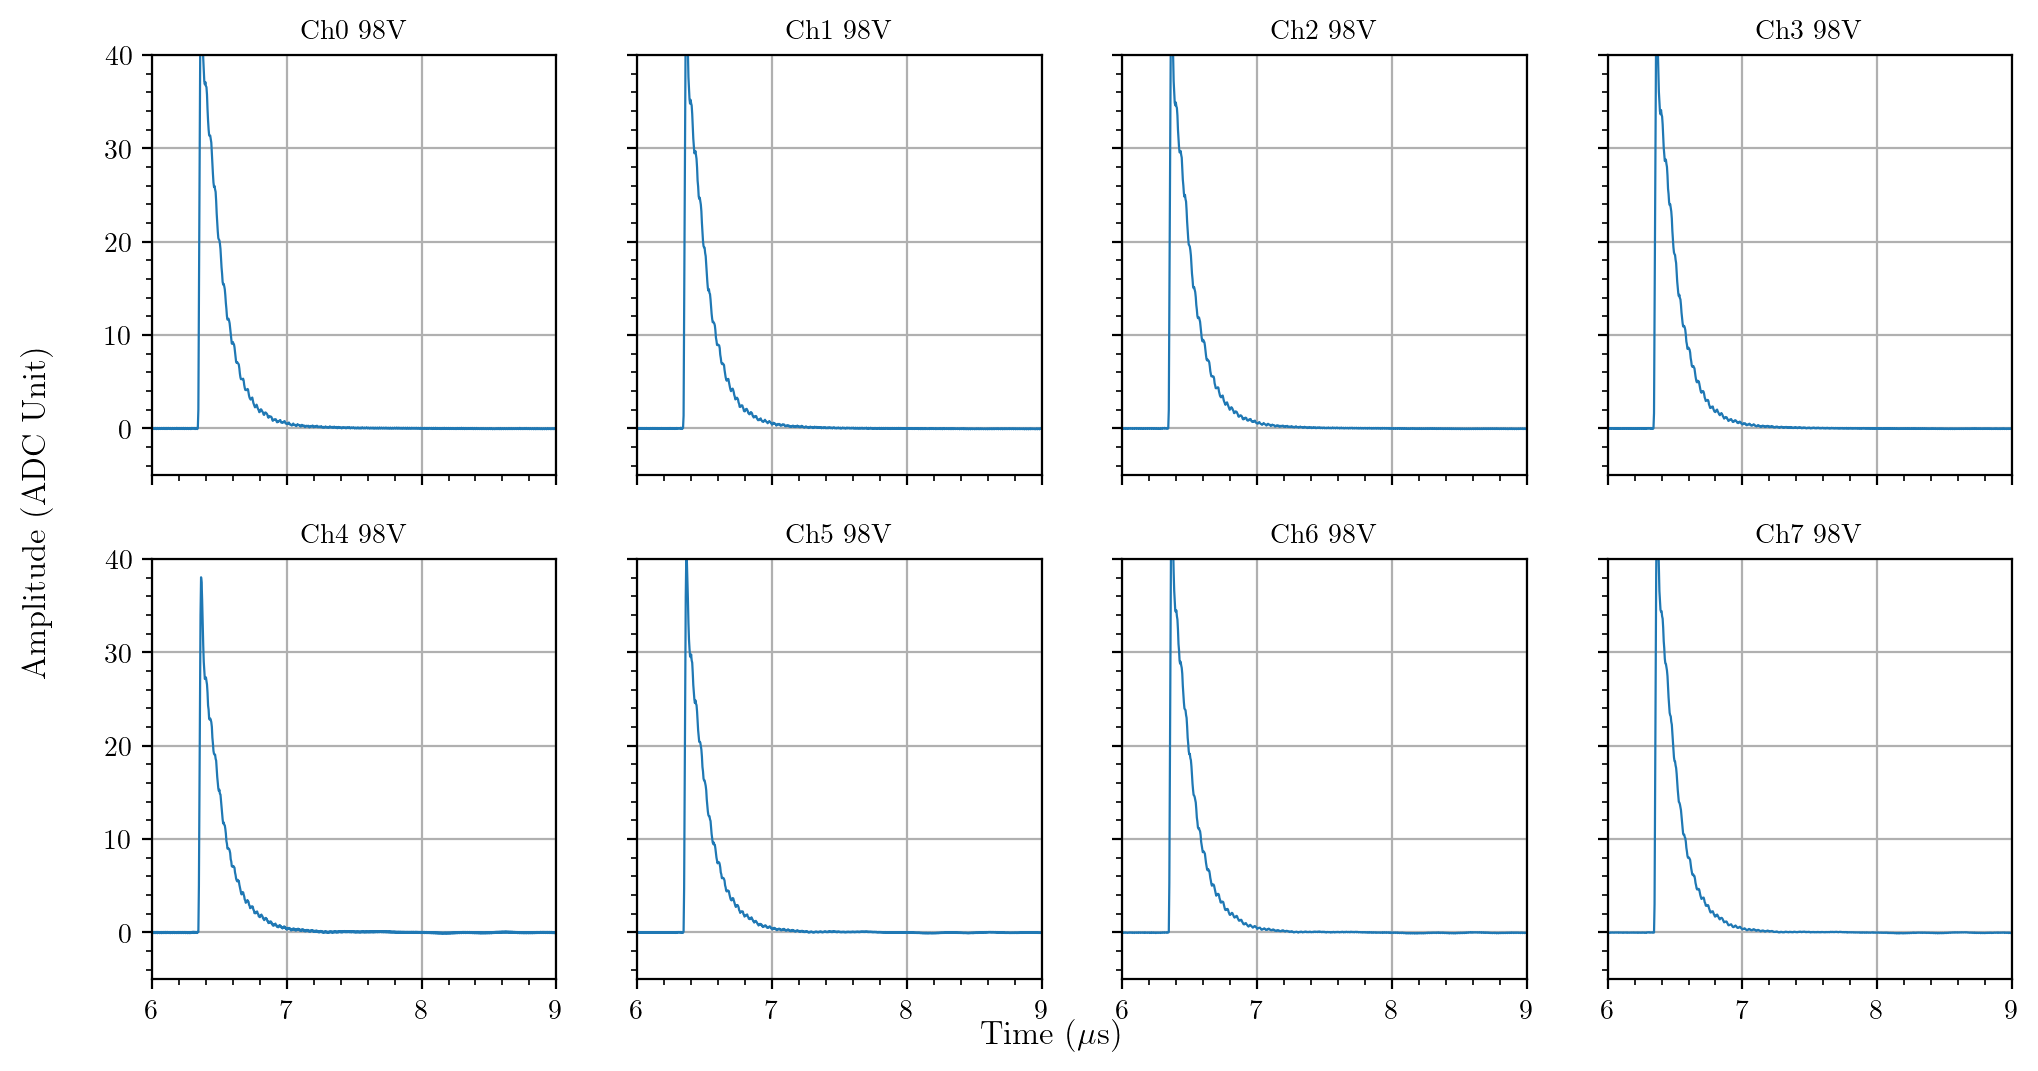

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    if data_spe[ch]['n_spe_wfs']>0:
        print(f'ch{ch} {volt}V {data_spe[ch]["n_spe_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_spe[ch]['time'],
            data_spe[ch]['avg_spe_wf'],linewidth=0.8)
    axs[j//4, j%4].set_xlim(6, 9)
    axs[j//4, j%4].set_ylim(-5, 40)
    # axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

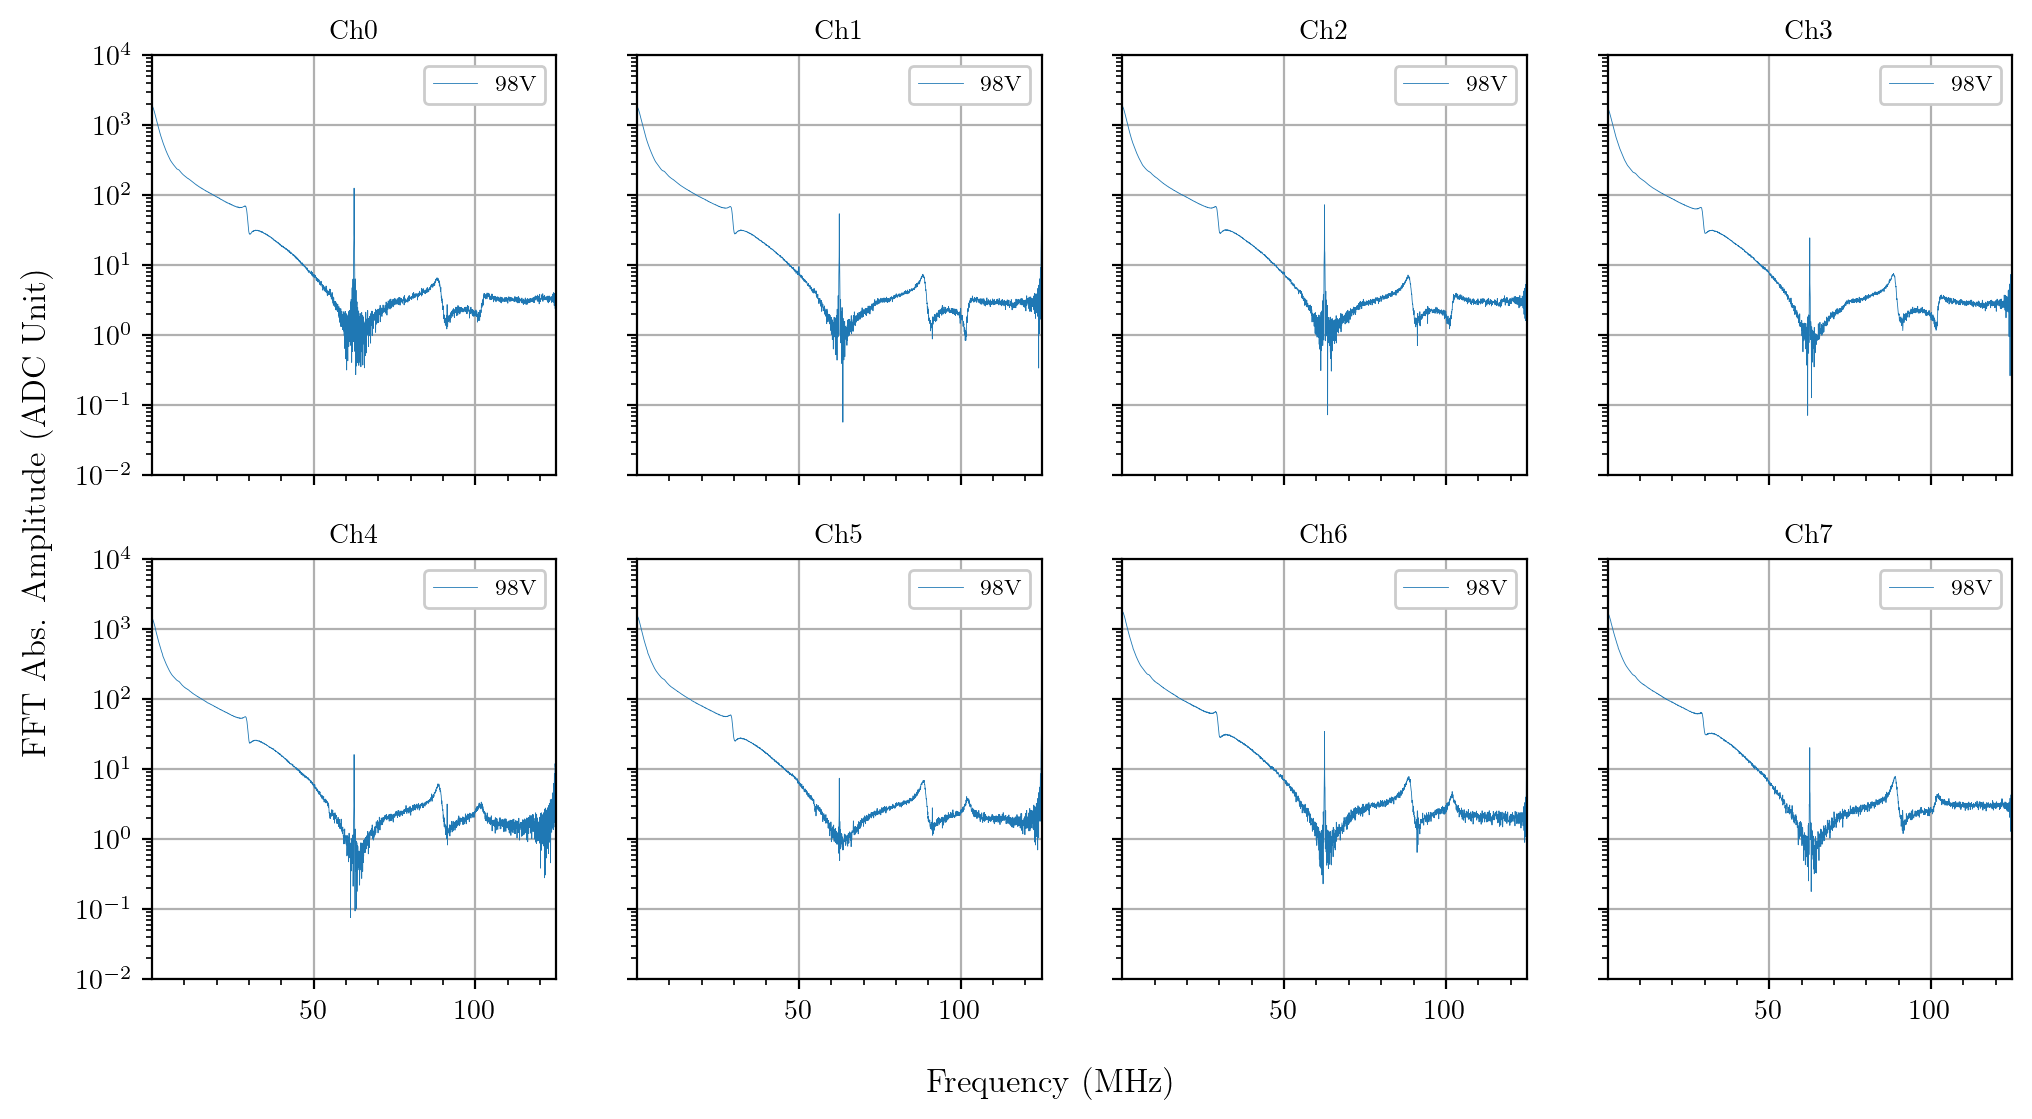

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    data_spe[ch]['fft_spe_wf'] = fft(data_spe[ch]['avg_spe_wf'])
    dt = data_spe[ch]['time'][1]-data_spe[ch]['time'][0]
    t_total = dt+data_spe[ch]['time'][-1]
    n_over_2 = int(data_spe[ch]['time'].shape[0]/2)
    data_spe[ch]['frequency'] = data_spe[ch]['time']/dt/t_total
    axs[j//4, j%4].plot(
        data_spe[ch]['frequency'][:n_over_2],
        abs(data_spe[ch]['fft_spe_wf'][:n_over_2]),
        label=f'{volt}V', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right')
    axs[j//4, j%4].set_xlim(data_spe[ch]['frequency'][1], data_spe[ch]['frequency'][n_over_2])
    axs[j//4, j%4].set_ylim(1e-2, 1e4)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [6]:
def template(t, a_1, tau_1, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0)

In [7]:
# Fit SPE average waveform
for j, ch in enumerate(channels):
    pretrg = 5 #us
    err = np.std(data_spe[ch]['avg_spe_wf'][data_spe[ch]['time']<pretrg])
    fit_range = [6.2,7.5] #us
    range_arr = (data_spe[ch]['time']<fit_range[1])&(data_spe[ch]['time']>fit_range[0])
    # print(pos,ch,volt)
    # print(data_spe[pos][ch][volt]['time'][range_arr])
    # print(data_spe[pos][ch][volt]['avg_spe_wf'][range_arr])
    popt,pcov = curve_fit(
        template,
        data_spe[ch]['time'][range_arr], 
        data_spe[ch]['avg_spe_wf'][range_arr], 
        p0=[20, 0.15, 0.005, 6.35], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
    data_spe[ch]['pars'] = popt
    data_spe[ch]['cov'] = pcov
    print(popt)

[5.18882743e+01 1.45652187e-01 5.24822755e-03 6.35197886e+00]
[4.89816504e+01 1.47975857e-01 5.04287800e-03 6.35189741e+00]
[4.85542993e+01 1.51878563e-01 4.94892909e-03 6.35147961e+00]
[4.73832736e+01 1.47520794e-01 5.00433097e-03 6.35165182e+00]
[3.85683043e+01 1.47689731e-01 4.80248889e-03 6.35362990e+00]
[4.15716795e+01 1.46750985e-01 4.89224968e-03 6.35379402e+00]
[4.82421692e+01 1.46867383e-01 5.04640953e-03 6.35411272e+00]
[4.85213927e+01 1.40289918e-01 5.07136632e-03 6.35516146e+00]


# Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [8]:
S_PER_HR = 3600
dt_getter = datetime(2024,4,18,15,43,0)
print('The getter was turned on at', dt_getter)

# dt_xe1 = datetime(2024,2,28,16,33,0)
# print('Xenon injection #1 at', dt_xe1)

# dt_xe2 = datetime(2024,3,6,15,0,0)
# print('Xenon injection #2 at', dt_xe2)

# dt_xe3 = datetime(2024,3,12,17,11,0)
# print('Xenon injection #3 at', dt_xe3)

# dt_xe4 = datetime(2024,3,19,15,0,0)
# print('Xenon injection #4 at', dt_xe4)

# dt_xe5 = datetime(2024,3,25,20,0,0)
# print('Xenon injection #5 at', dt_xe5)

The getter was turned on at 2024-04-18 15:43:00


In [9]:
# Pure LAr
path = "/scratch/gpfs/pk9185/results/"
dates = ['2024-05-08','2024-05-14']
files = []
for d in dates:
    files.extend(glob.glob(f"{path}{d}/*source_ambe_*xenon_*scintillation_waveform_liq7.h5"))
for i,f in enumerate(files):
    files[i] = [files[i]]
print(files)
print(len(files))

# Xe injection monitoring
# path = "/scratch/gpfs/as111/results/"
# dates = ['2024-02-28','2024-03-01','2024-03-04', # injection #1
#          '2024-03-06','2024-03-08', '2024-03-11', # injection #2
#          '2024-03-12','2024-03-18', # injection #3
#          '2024-03-19', # injection #4
#          '2024-03-25'  # injection #5
#         ]
# files = []
# for d in dates:
#     files.extend(glob.glob(f"{path}{d}/*cond_monitor*scintillation_waveform_liq6.h5"))
# for i,f in enumerate(files):
#     files[i] = [files[i]]
# print(files)
# print(len(files))

[['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run2_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run4_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run6_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run5_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run3_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt_98_light_scintillation_cond_neutron_2pe_source_ambe_xenon_0_run9_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/pk9185/results/2024-05-08/2024-05-08_volt

In [10]:
# data folder
data_scint = {}
date_time = {}
channels = np.arange(8)
channels_nofs = [1,2,4,7] 
channels_fs = [0,3,5,6]
ch_old = [0,5,6,3,4,1,2,7] # map to channels in liq5 calibration data
volt = 98
for i,fs in enumerate(files):
    data_scint[i] = {}
    for j,f in enumerate(fs):
        df = pd.read_hdf(f, key=f'{volt}/-1')
        if j==0:
            date_time[i] = datetime(*np.array(df['start_datetime'][:6]).astype(int))
        for ch in channels:
            if j==0:
                data_scint[i][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data_scint[i][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
            if data_scint[i][ch]['time'].shape[0]==0:
                data_scint[i][ch]['time'] = np.array(df['time'].dropna())
            if data_scint[i][ch]['avg_scint_wf'].shape[0]==0:
                data_scint[i][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            else:
                data_scint[i][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[i][ch]['avg_scint_wf'] /= data_scint[i][ch]['n_scint_wfs']
# sort according to date time
args = np.array(list(date_time.values())).argsort()
files = [files[i] for i in args]
data_scint = [data_scint[i] for i in args]
date_time = [date_time[i] for i in args]
# hr_from_inject = [(dt-dt_xe1).total_seconds()/S_PER_HR for dt in date_time]
hr_from_getter = [(dt-dt_getter).total_seconds()/S_PER_HR for dt in date_time]

2024-05-08 11:37:21 ch0 780 waveforms selected
2024-05-08 11:53:59 ch0 823 waveforms selected
2024-05-08 12:10:27 ch0 794 waveforms selected
2024-05-08 12:26:47 ch0 697 waveforms selected
2024-05-08 12:41:19 ch0 768 waveforms selected
2024-05-08 12:56:43 ch0 738 waveforms selected
2024-05-08 13:11:54 ch0 766 waveforms selected
2024-05-08 13:27:43 ch0 812 waveforms selected
2024-05-08 13:43:54 ch0 787 waveforms selected
2024-05-08 14:00:31 ch0 790 waveforms selected
2024-05-14 10:26:55 ch0 366 waveforms selected
2024-05-14 10:42:29 ch0 385 waveforms selected
2024-05-14 10:58:08 ch0 376 waveforms selected
2024-05-14 11:13:53 ch0 400 waveforms selected
2024-05-14 11:29:31 ch0 367 waveforms selected
2024-05-14 11:45:38 ch0 370 waveforms selected
2024-05-14 12:02:10 ch0 391 waveforms selected
2024-05-14 12:18:20 ch0 393 waveforms selected
2024-05-14 12:34:20 ch0 394 waveforms selected
2024-05-14 12:50:20 ch0 389 waveforms selected
2024-05-08 11:37:21 ch1 780 waveforms selected
2024-05-08 11

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

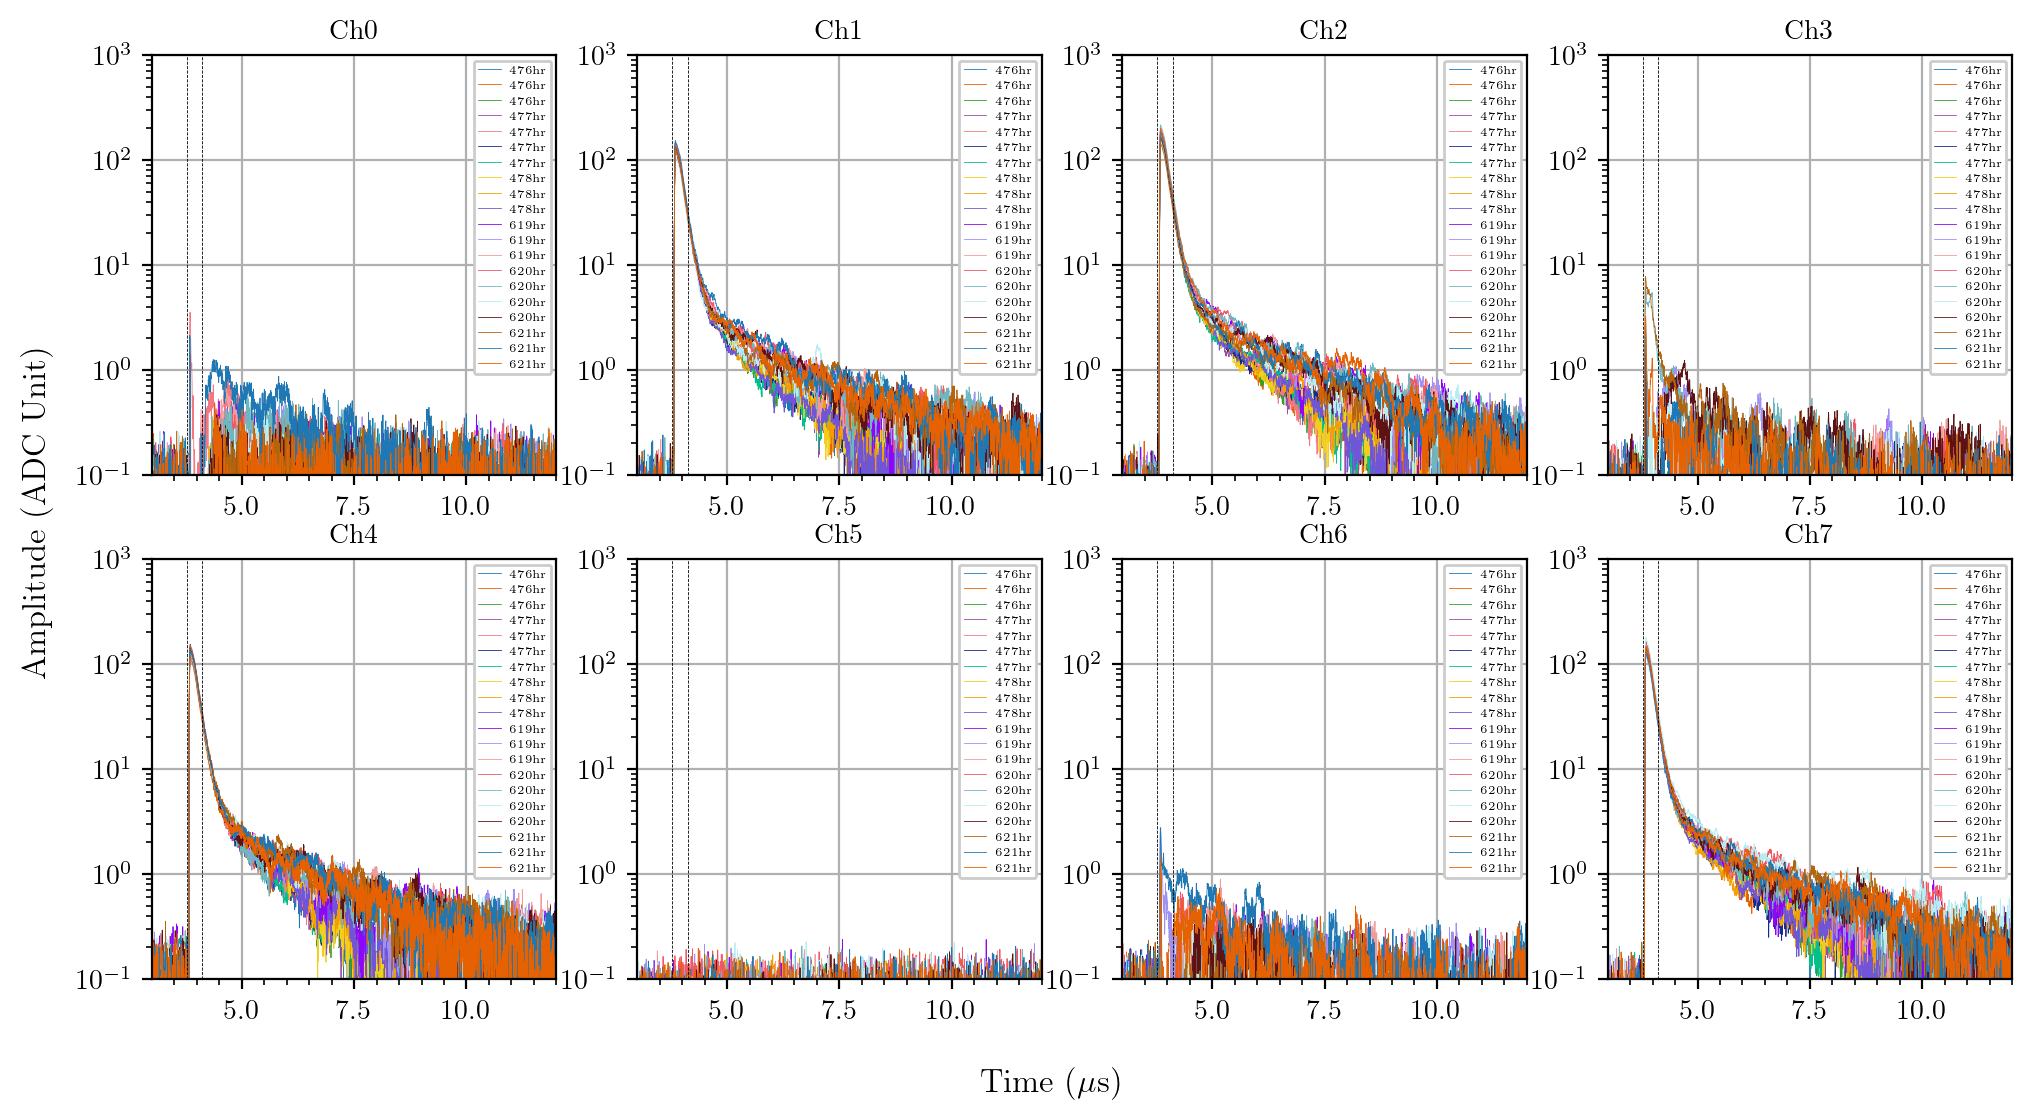

In [11]:
# Make plots for all datasets
# Average LAr scintillation waveform
t_trig = 3.82
ylims = (1e-1,1e3)
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files[:20]):
        print(f'{date_time[k]} ch{ch} {data_scint[k][ch]["n_scint_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_scint[k][ch]['time'],
            data_scint[k][ch]['avg_scint_wf'],
            label=f'{hr_from_getter[k]:.0f}hr', color=f'C{k}', linewidth=0.3)
            # label=f'{hr_from_inject[k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right',fontsize=4)
    axs[j//4, j%4].set_xlim(3, 12)
    axs[j//4, j%4].set_ylim(*ylims)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
    axs[j//4, j%4].plot([t_trig-10*0.004]*2, ylims, 'k--',linewidth=0.3)
    axs[j//4, j%4].plot([t_trig+0.3]*2, ylims, 'k--',linewidth=0.3)
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [12]:
# Deconvolution channel by channel
for i, f in enumerate(files):
    for j, ch in enumerate(channels):
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch_old[ch]]['n_spe_wfs']>0:
            dt = data_spe[ch_old[ch]]['time'][1]-data_spe[ch_old[ch]]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[ch_old[ch]]['pars'][3]/dt))) for freq in data_spe[ch_old[ch]]['frequency']])
            data_scint[i][ch]['deconv'] = ifft(fft(data_scint[i][ch]['avg_scint_wf'])/data_spe[ch_old[ch]]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

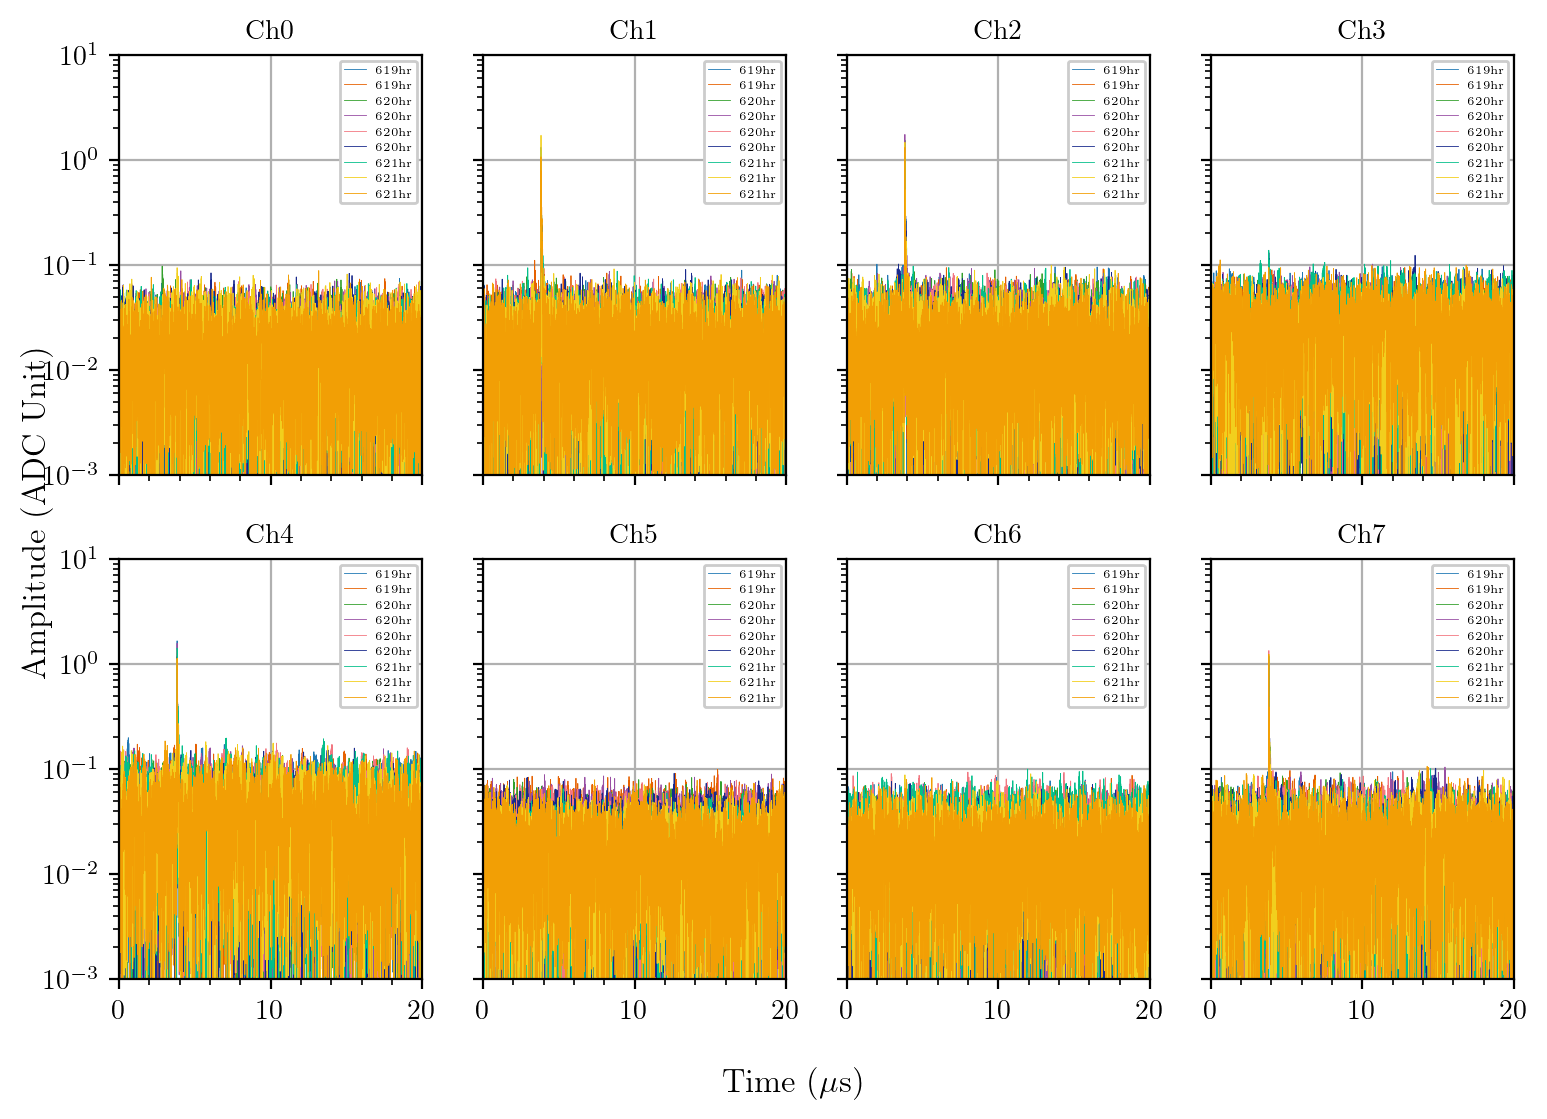

In [13]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(9, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files[-9:]):
        if data_scint[-9+k][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            axs[j//4, j%4].plot(
                data_scint[-9+k][ch]['time'],
                abs(data_scint[-9+k][ch]['deconv']),
                label=f'{hr_from_getter[-9+k]:.0f}hr', color=f'C{k}', linewidth=0.3)
                # label=f'{hr_from_inject[-12+k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right', fontsize=4)
    axs[j//4, j%4].set_xlim(0, 20)
    axs[j//4, j%4].set_ylim(1e-3, 1e1)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation + Subsampling

In [14]:
def subsample(input_t,input_wf,nsub):
    ntot = int(input_t.shape[0]//nsub * nsub)
    new_t, new_wf = np.zeros(ntot//nsub), np.zeros(ntot//nsub)
    for i in range(nsub):
        new_t += input_t[i:ntot:nsub]
        new_wf += input_wf[i:ntot:nsub]
    new_t /= nsub
    new_wf /= nsub
    return new_t, new_wf

In [15]:
# summation
for i,f in enumerate(files):
    data_scint[i][-1] = {'time': data_scint[i][0]['time'], 'sum_wf_nofs': np.zeros(data_scint[i][0]['time'].shape[0]),'sum_wf_fs': np.zeros(data_scint[i][0]['time'].shape[0])}
    for ch in channels_nofs:    
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_nofs'] += data_scint[i][ch]['deconv']
    for ch in channels_fs:
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_fs'] += data_scint[i][ch]['deconv']

In [16]:
# subsampling
nsub = 4
for i,f in enumerate(files):
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_nofs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_nofs'],nsub)
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_fs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_fs'],nsub)

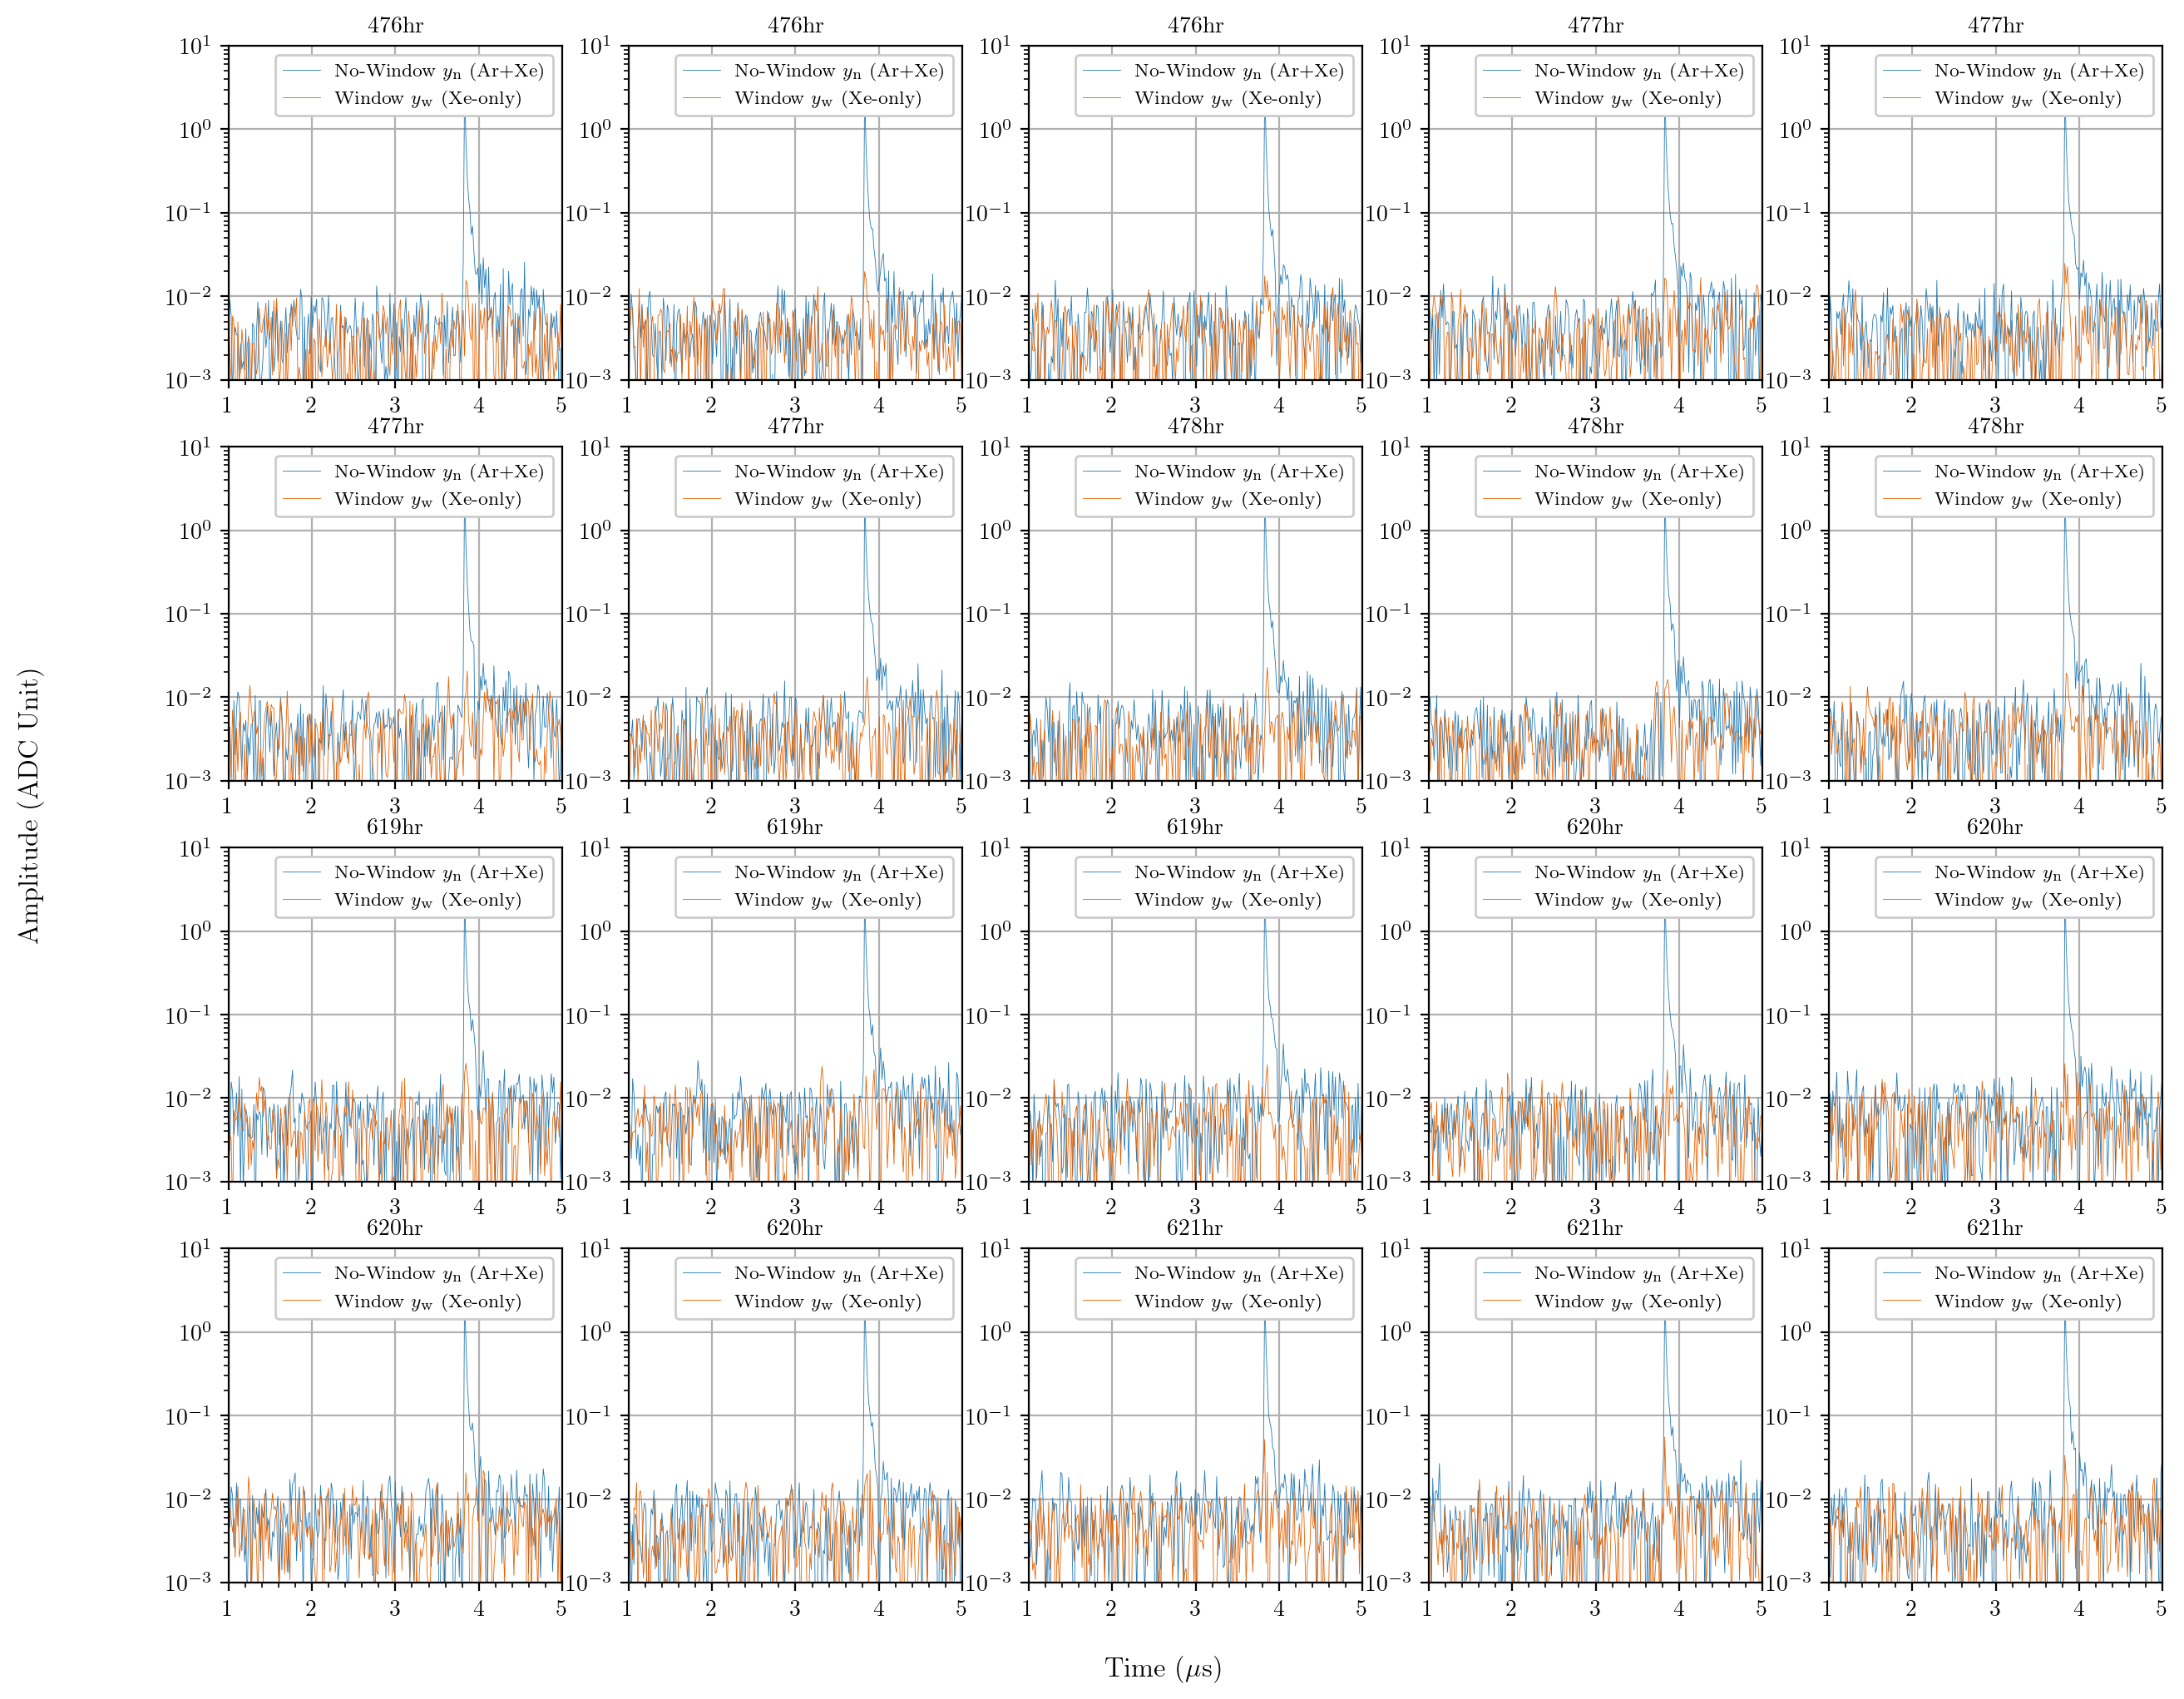

In [17]:
# Make plots for all datasets
# Summed scintillation waveform
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
nofs_total_pe = []
fs_total_pe = []
for i, f in enumerate(files):
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_nofs']),
                linewidth=0.3,label=r'No-Window $y_{\rm n}$ (Ar+Xe)')
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_fs']),
                linewidth=0.3, label=r'Window $y_{\rm w}$ (Xe-only)')
    axs[i//5, i%5].set_xlim(1, 5)
    axs[i//5, i%5].set_ylim(1e-3, 1e1)
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    # axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
    axs[i//5, i%5].set_title(f'{hr_from_getter[i]:.0f}hr')
    axs[i//5, i%5].legend(loc='upper right')
    nofs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_nofs'])*nsub)
    fs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_fs'])*nsub)
fig.supxlabel(r'Time ($\mu$s)', y=0.06)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.04)
nofs_total_pe = np.array(nofs_total_pe)
fs_total_pe = np.array(fs_total_pe)

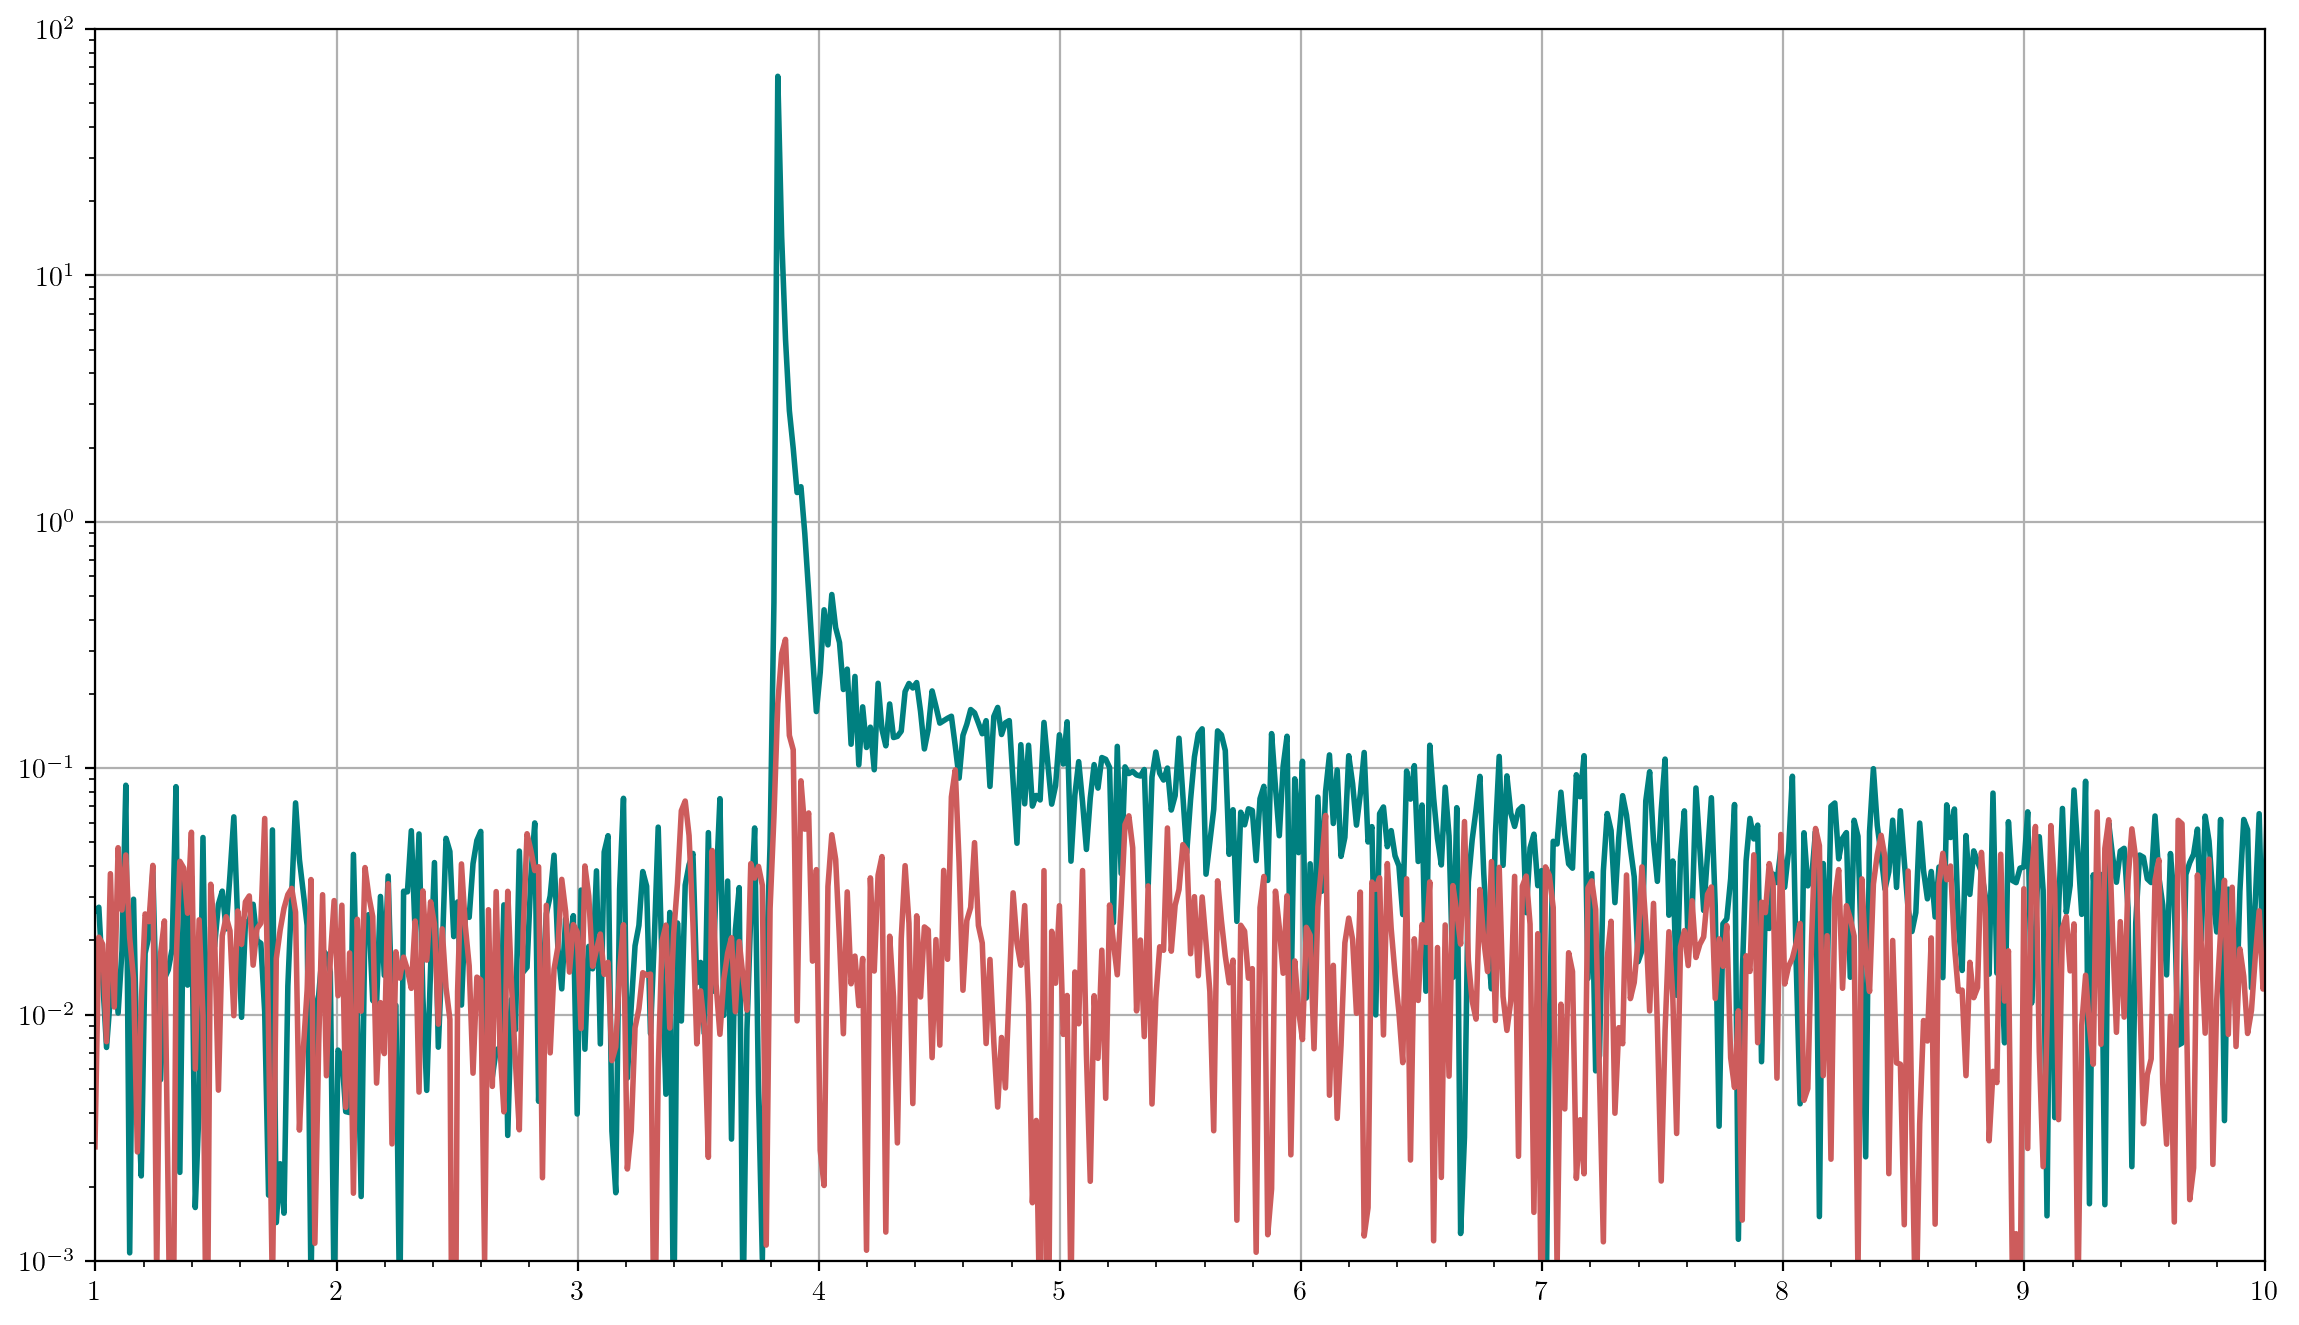

In [18]:
wave_tot = np.zeros(len(data_scint[0][-1]['sum_wf_sub_nofs']))
win_wave_tot = np.zeros(len(data_scint[0][-1]['sum_wf_sub_fs']))
for i, f in enumerate(files):
    wave_tot+=data_scint[i][-1]['sum_wf_sub_nofs']
    win_wave_tot += data_scint[i][-1]['sum_wf_sub_fs']
plt.figure(figsize=(14,8))
plt.plot(data_scint[0][-1]['time_sub'],
         abs(wave_tot),lw=2,c='teal')
plt.plot(data_scint[0][-1]['time_sub'],
         abs(win_wave_tot),lw=2,c='indianred')
plt.xlim(1, 10)
plt.ylim(1e-3, 1e2)
plt.yscale('log')
plt.minorticks_on()
plt.grid()

In [19]:
# def template4(t,a1,tau1,a2,tau2):
#     t = t-6.22
#     return a1/tau1*np.exp(-t/tau1) + a2/(tau2-tau1)*(np.exp(-t/tau2)-np.exp(-t/tau1))

In [20]:
# for i in range(10):
#     plt.figure(i,figsize=(3,3))
#     ylims = (1e-3,1e1)
#     y = data_scint[i][-1]['sum_wf_sub_nofs'] - 1.32*data_scint[i][-1]['sum_wf_sub_fs']
#     plt.plot(
# 		data_scint[i][-1]['time_sub'],
# 		abs(y),
# 		linewidth=0.3,label=r'No-Window $y_{\rm n}$ (Ar+Xe)')
    
#     t_arr = np.linspace(6.22,16,200)
#     a1, tau1, a2, tau2 = 0.13,1,0.2,3
#     fit_range = [6.6,13] #us
#     pretrg = 5.0
#     range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
#     err = np.std(y[data_scint[i][-1]['time_sub']<pretrg])
#     popt,pcov = curve_fit(
# 		template4,
# 		data_scint[i][-1]['time_sub'][range_arr],
# 		y[range_arr], 
# 		p0=[a1,tau1,a2,tau2], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
    
#     plt.plot(t_arr, template4(t_arr,*popt),'r--',linewidth=0.6)
#     plt.plot([fit_range[0]]*2,ylims,'k--',linewidth=0.6)
#     plt.plot([fit_range[1]]*2,ylims,'k--',linewidth=0.6)
#     plt.title('{:.3f} {:.3f} {:.3f} {:.3f}'.format(*popt))
    
#     plt.grid()
#     plt.minorticks_on()
#     plt.legend(loc='upper right')
#     plt.yscale('log')
#     plt.ylim(*ylims)
#     plt.xlim(6,16)

## Fitting

In [21]:
# def template2(t, a_1, tau_1, a_2, tau_2, sigma, t0):
#         return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [22]:
def template3(t,a,tau,trig=6.22):
    return a/tau*0.004*np.exp(-(t-trig)/tau)

In [23]:
class LArXePulseShape():
    def __init__(self, xe_pulse, t_trig):
        """_summary_

        Args:
            xe_pulse (tuple): xe_pulse = [time_array, amplitude_array] for xenon-only pulse
        """
        self.t_arr = xe_pulse[0]
        self.xe_pulse_y = xe_pulse[1]
        self.t_trig = t_trig

    def get_pulse_model(self, a, tau, a_xe=1.33):
        t = self.t_arr-self.t_trig
        pulse_model = a/tau*0.004*np.exp(-t/tau) + a_xe*self.xe_pulse_y # sample interval = 0.004us
        return pulse_model
        
    def fit_to_data(self, data_y, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            a, tau, a_xe = x[0], x[1], x[2]
            ar_xe_pulse = args
            ans = (ar_xe_pulse-self.get_pulse_model(a, tau, a_xe))
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (self.t_arr<fit_range[1]) & (self.t_arr>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data_y,bounds=(0,np.inf))
        cov = np.linalg.inv(res.jac.T@res.jac)
        return res.x, cov
        

In [24]:
# Fit SPE average waveform
data_sub = {}
t_trig = 3.82
for i,f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        pretrg = 3.5 #us
        # simple exponential fit to windowless
        fit_range = [4.5,9] #us
        # windowed + simple exponential fit to windowless
        # fit_range = [6.35,10] #us
        err = np.std(data_scint[i][-1]['sum_wf_sub_nofs'][data_scint[i][-1]['time_sub']<pretrg])
        
        # simple exponential fit to windowless
        range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
        popt,pcov = curve_fit(
            template3,
            data_scint[i][-1]['time_sub'][range_arr], 
            data_scint[i][-1]['sum_wf_sub_nofs'][range_arr], 
            p0=[100,1], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        
        # windowed + simple exponential fit to windowless
        # ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'],data_scint[i][-1]['sum_wf_sub_fs']/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub), t_trig=t_trig)
        # popt, pcov = ar_xe_pulse_fit.fit_to_data(data_scint[i][-1]['sum_wf_sub_nofs'],sigma=err*np.ones_like(data_scint[i][-1]['time_sub']),x0=[50,0.6,30],fit_range=fit_range)
        
        data_scint[i][-1]['pars'] = popt
        data_scint[i][-1]['cov'] = pcov
        data_scint[i][-1]['pars_err'] = np.array([func.error_distance(df=2, sigma=1)*pcov[j,j]**0.5 for j in range(len(popt))])
        data_scint[i][-1]['fit_range'] = fit_range
        
        # windowed + simple exponential fit to windowless
        # print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us A_Xe = {popt[2]:.3f}+/-{data_scint[i][-1]["pars_err"][2]:.3f}')

        # simple exponential fit to windowless
        print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us')
        

2024-05-08 11:37:21 A=1.25+/-0.66 tau=1.844+/-0.638us
2024-05-08 11:53:59 A=1.36+/-0.74 tau=2.108+/-0.813us
2024-05-08 12:10:27 A=1.63+/-0.82 tau=2.371+/-0.895us
2024-05-08 12:26:47 A=1.59+/-0.89 tau=2.305+/-0.954us
2024-05-08 12:41:19 A=1.46+/-0.76 tau=2.134+/-0.795us
2024-05-08 12:56:43 A=1.48+/-0.86 tau=2.211+/-0.930us
2024-05-08 13:11:54 A=1.51+/-0.86 tau=2.267+/-0.951us
2024-05-08 13:27:43 A=1.62+/-1.01 tau=2.441+/-1.155us
2024-05-08 13:43:54 A=1.69+/-0.98 tau=2.519+/-1.128us
2024-05-08 14:00:31 A=1.68+/-0.89 tau=2.485+/-1.010us
2024-05-14 10:26:55 A=3.12+/-2.13 tau=3.243+/-1.893us
2024-05-14 10:42:29 A=2.52+/-1.43 tau=2.547+/-1.118us
2024-05-14 10:58:08 A=2.91+/-1.63 tau=2.812+/-1.272us
2024-05-14 11:13:53 A=3.05+/-1.62 tau=2.896+/-1.259us
2024-05-14 11:29:31 A=2.84+/-1.66 tau=2.886+/-1.377us
2024-05-14 11:45:38 A=3.07+/-2.04 tau=3.085+/-1.715us
2024-05-14 12:02:10 A=3.38+/-2.03 tau=3.506+/-1.841us
2024-05-14 12:18:20 A=3.66+/-2.41 tau=3.759+/-2.208us
2024-05-14 12:34:20 A=2.97+/

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

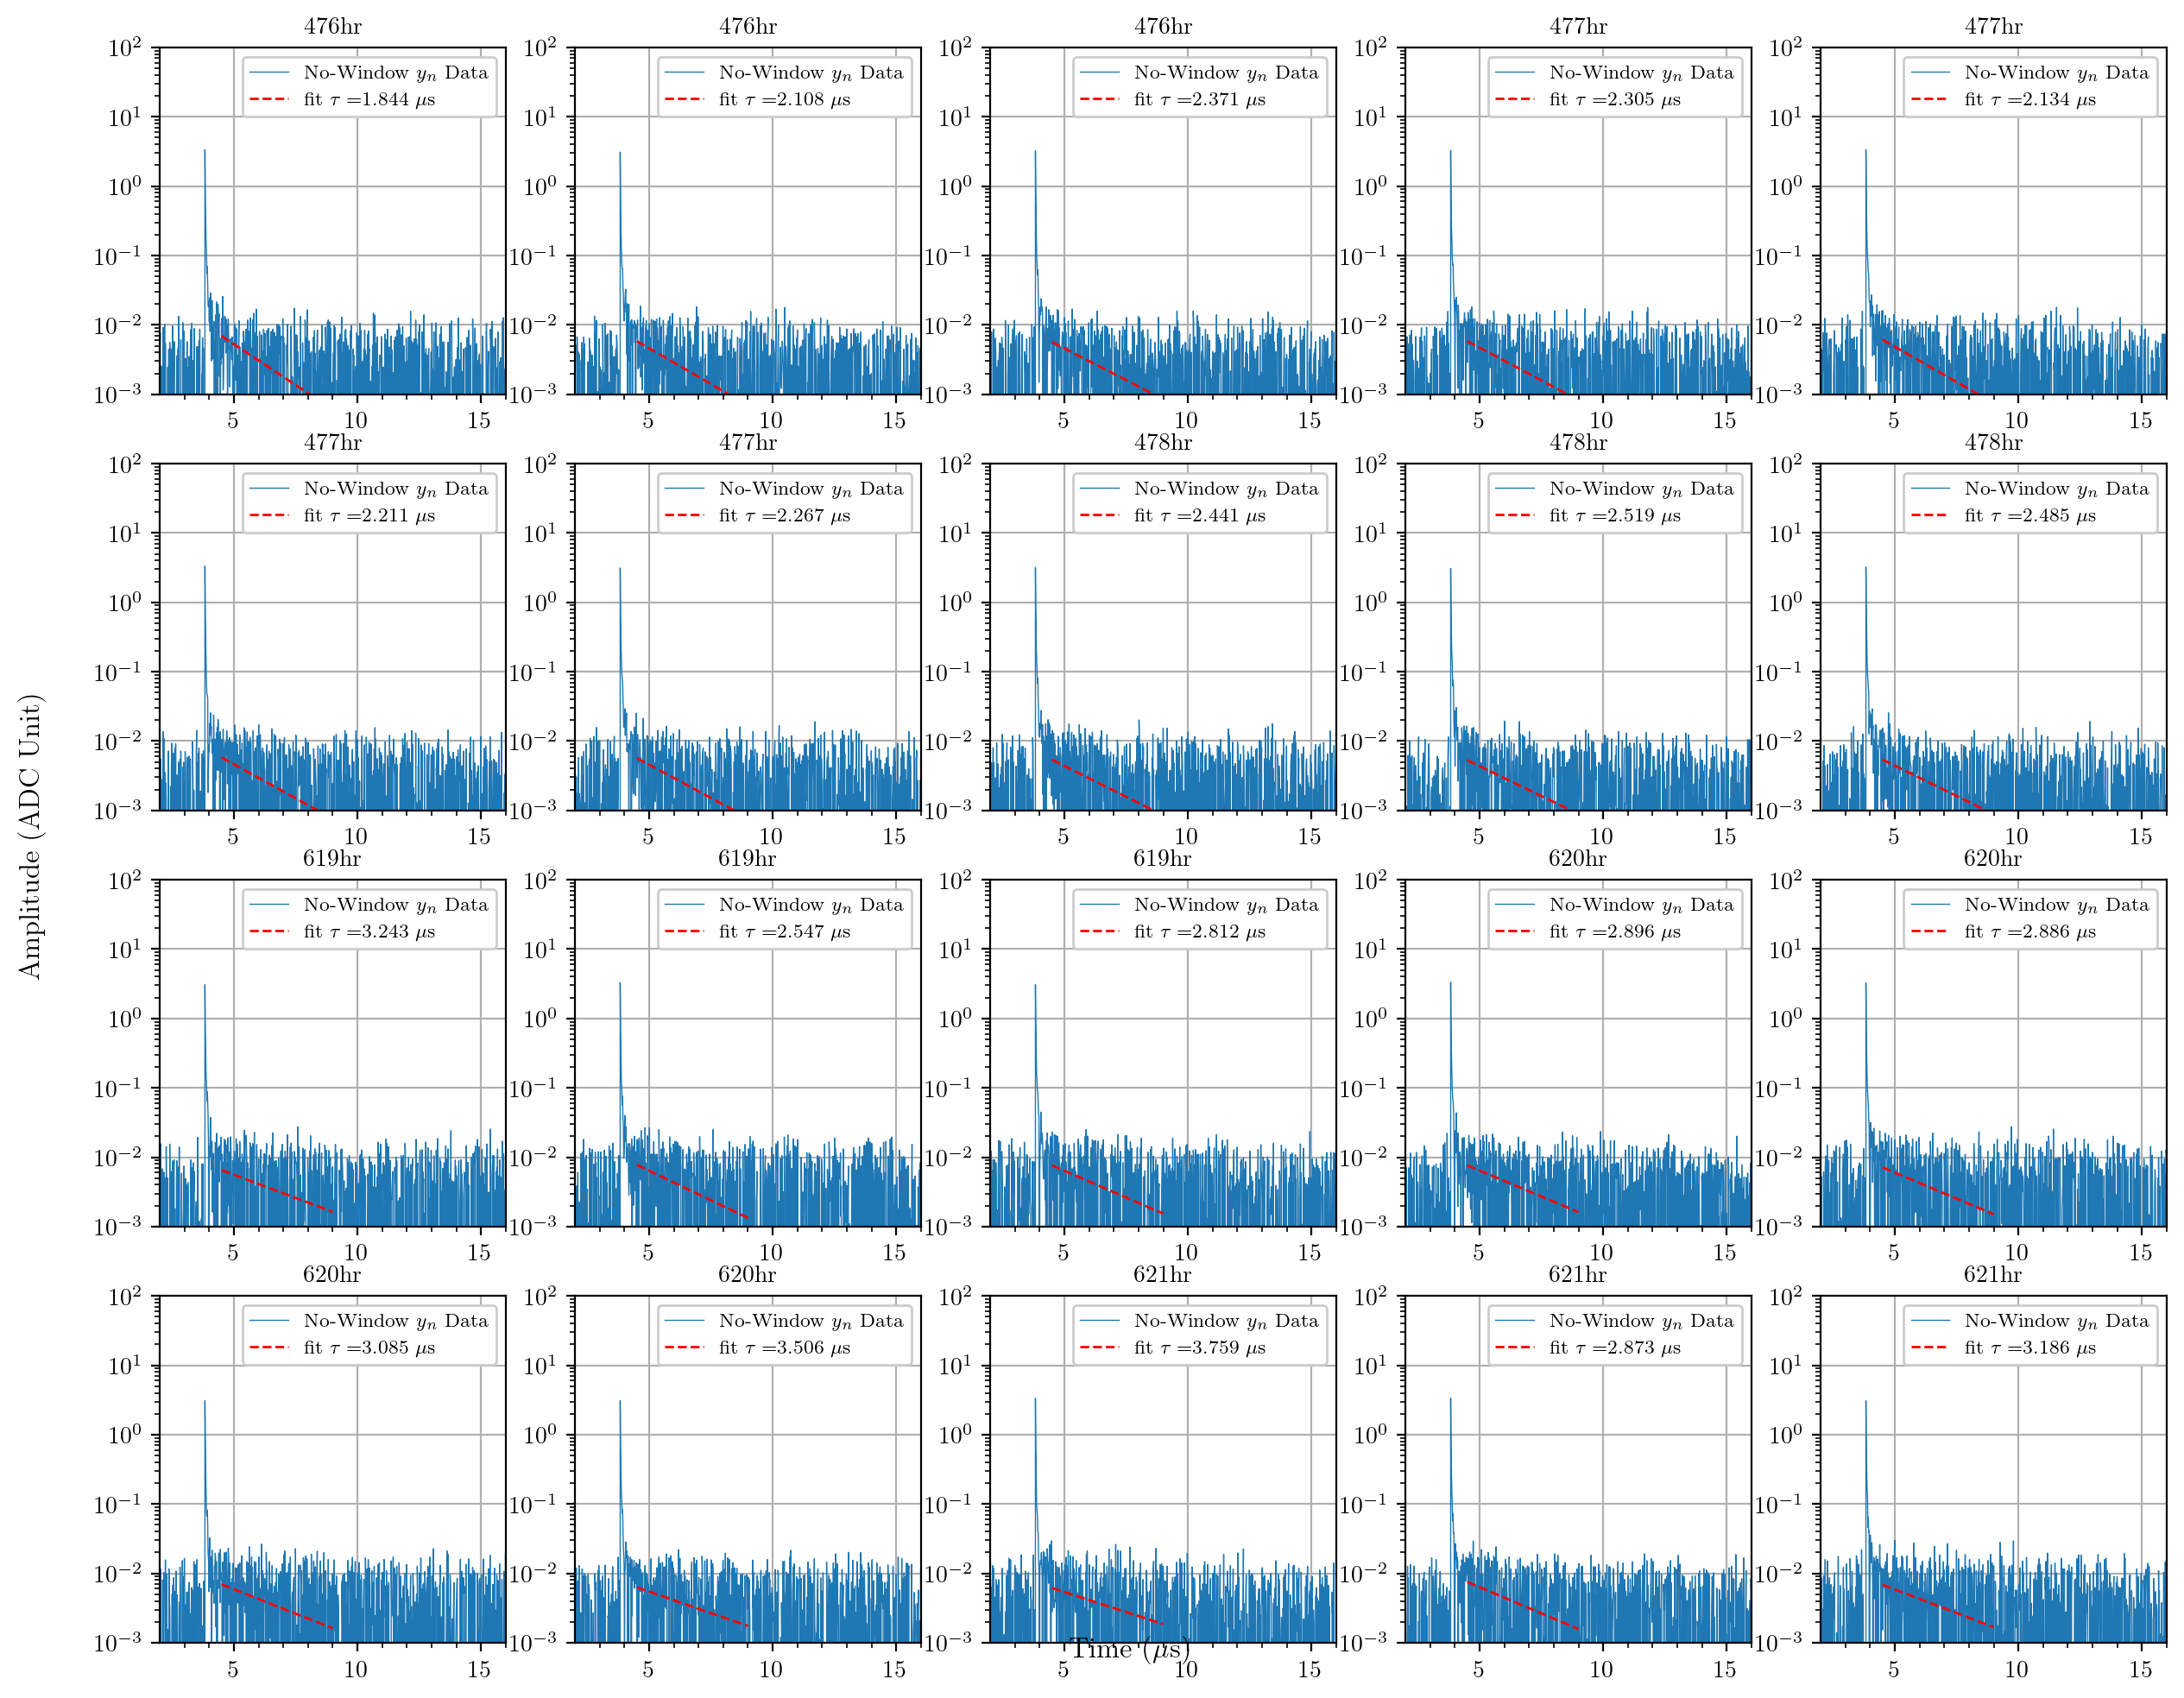

In [25]:
# Make plots for all datasets
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'],
            data_scint[i][-1]['sum_wf_sub_nofs'],
            label=r'No-Window $y_n$ Data', color='C0', linewidth=0.5)
        mask = (data_scint[i][-1]['time_sub']>data_scint[i][-1]['fit_range'][0]) & (data_scint[i][-1]['time_sub']<data_scint[i][-1]['fit_range'][1])
        
        # simple exponential fit to windowless
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            template3(data_scint[i][-1]['time_sub'][mask], *data_scint[i][-1]['pars']),
            label=r'fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='r', linestyle='--', linewidth=1)
        
        # windowed + simple exponential fit to windowless
        # ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'][mask],data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub),t_trig=t_trig)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars']),
        #     label=r'No-Window $y_n$ Fit', color='C1', linestyle='-', linewidth=1)
        #     # label=r'No FS fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='C1', linestyle='-', linewidth=1)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars'][:-1], a_xe=0),
        #     label=r'Ar-only', color='C2', linestyle='--', linewidth=1)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     data_scint[i][-1]['pars'][-1]*data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub,
        #     label=r'Xe-only', color='C3', linestyle='--', linewidth=1)
        
        axs[i//5, i%5].legend(loc='upper right',ncol=1)
        axs[i//5, i%5].set_xlim(2, 16)
        axs[i//5, i%5].set_ylim(1e-3, 1e2)
        axs[i//5, i%5].set_yscale('log')
        axs[i//5, i%5].minorticks_on()
        axs[i//5, i%5].grid()
        # axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
        axs[i//5, i%5].set_title(f'{hr_from_getter[i]:.0f}hr')
fig.supxlabel(r'Time ($\mu$s)', y=0.1)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

# Triplet lifetime evolution

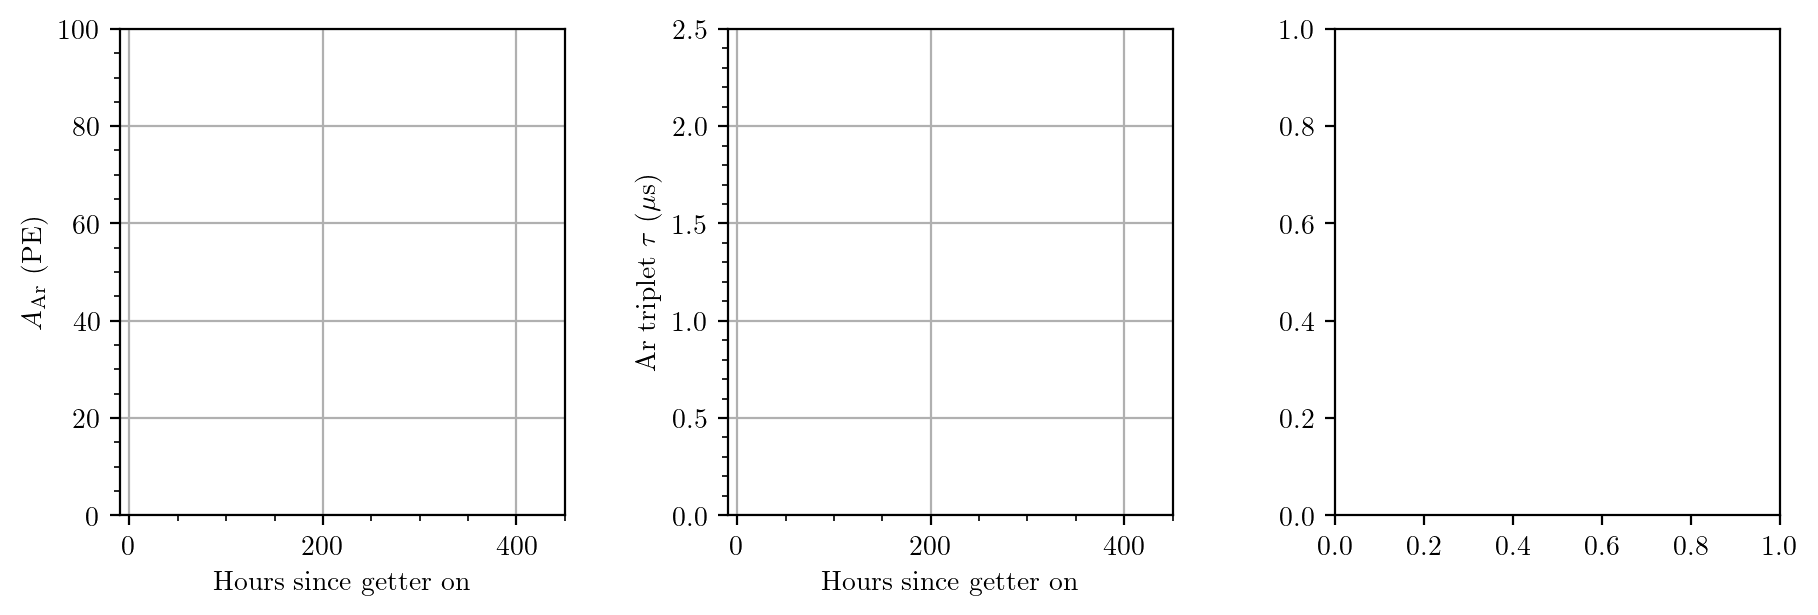

In [26]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=False)
fig.set_size_inches(9, 3)
fig.tight_layout(h_pad=3, w_pad=3)

ylabels = [r'$A_{\rm Ar}$ (PE)', r'Ar triplet $\tau$ ($\mu$s)', r'$A_{\rm Xe} (PE)$']
ylims = [(0,100),(0,2.5),(0,100)]

for i in range(2):
    axs[i].errorbar(
        # hr_from_inject,
        hr_from_getter,
        [data_scint[j][-1]['pars'][i] for j in range(len(files))],
        yerr=[func.error_distance(df=2, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][i,i]) for j in range(len(files))],
        linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
    )
    # axs[i].plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    # axs[i].plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    # axs[i].plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    # axs[i].plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_ylim(*ylims[i])
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_xlim(-10,450)
    axs[i].set_xlabel('Hours since getter on')

In [27]:
ylims = (-0,1.5)
plt.figure(0,figsize=(3,3))
plt.scatter(
    hr_from_inject,
	nofs_total_pe/nofs_total_pe[0],
	label='no FS', s=1
)
plt.scatter(
    hr_from_inject,
	fs_total_pe/nofs_total_pe[0],
	label='FS', s=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Relative Waveform Integral')
plt.xlabel('Hours since Xe injection')
plt.legend()

NameError: name 'hr_from_inject' is not defined

<Figure size 600x600 with 0 Axes>

: 

Text(0.5, 0, 'Hours since Xe injection')

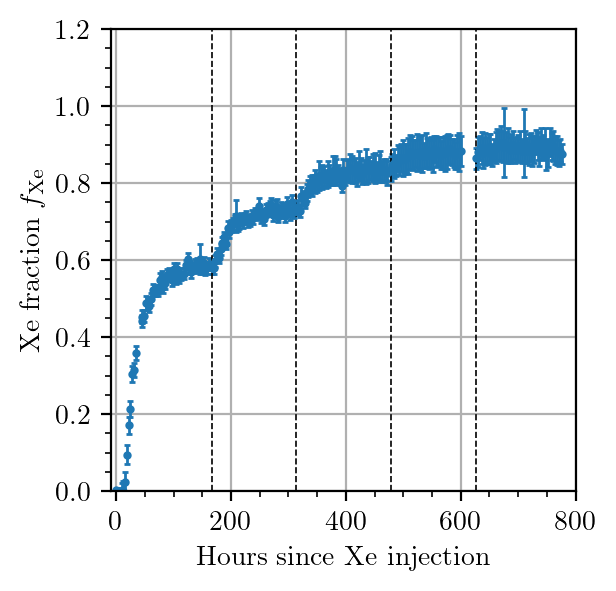

In [ ]:
ylims = (0,1.2)
plt.figure(0,figsize=(3,3))
plt.errorbar(
    hr_from_inject,
	np.array([data_scint[j][-1]['pars'][2] for j in range(len(files))])/nofs_total_pe,
	yerr=np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][2,2]) for j in range(len(files))])/nofs_total_pe,
	linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Xe fraction $f_{\rm Xe}$')
plt.xlabel('Hours since Xe injection')

NoFS-to-FS relative efficiency = 1.312+/-0.003+/-0.021


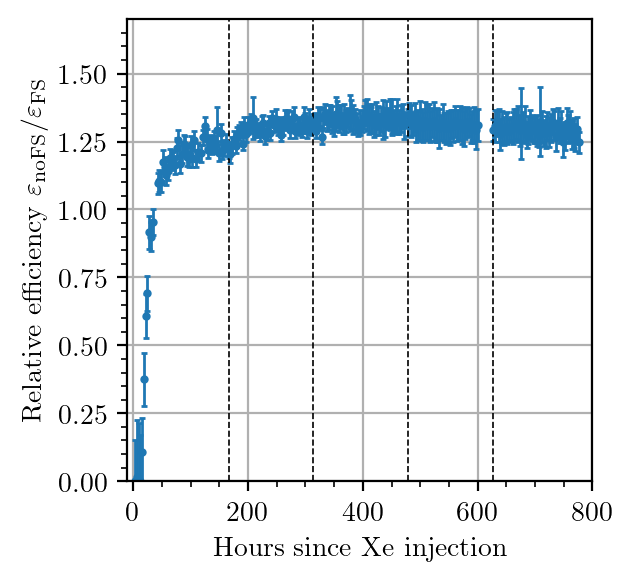

In [ ]:
ylims = (0,1.7)
plt.figure(0,figsize=(3,3))
rel_eff = np.array([data_scint[j][-1]['pars'][2] for j in range(len(files))])/fs_total_pe
rel_eff_err = np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][2,2]) for j in range(len(files))])/np.abs(fs_total_pe)
plt.errorbar(
    hr_from_inject,
	rel_eff,
	yerr=rel_eff_err,
	linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Relative efficiency $\varepsilon_{\rm no FS}/\varepsilon_{\rm FS}$')
plt.xlabel('Hours since Xe injection')
rel_eff_avg, rel_eff_avg_err = np.sum((rel_eff/(rel_eff_err)**2)[np.array(hr_from_inject)>250])/np.sum((rel_eff_err**(-2))[np.array(hr_from_inject)>250]), np.sum(rel_eff_err[np.array(hr_from_inject)>250]**(-2))**(-0.5)
print(f'NoFS-to-FS relative efficiency = {rel_eff_avg:.3f}+/-{rel_eff_avg_err:.3f}+/-{np.std(rel_eff[np.array(hr_from_inject)>250]):.3f}')

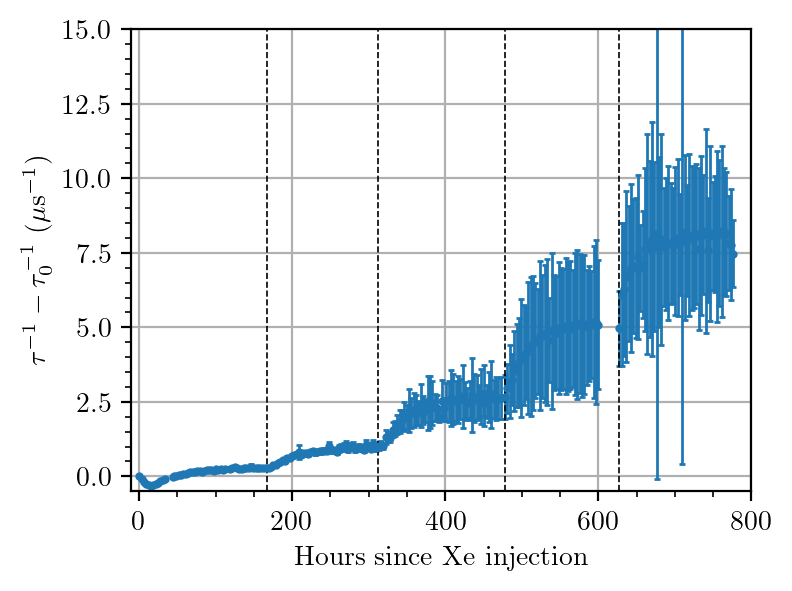

In [ ]:
ylims = (-0.5,15)
tau = np.array([data_scint[j][-1]['pars'][1] for j in range(len(files))])
tau_err = np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][1,1]) for j in range(len(files))])
tau0 = data_scint[0][-1]['pars'][1]
tau0_err = func.error_distance(df=2, sigma=1)*np.sqrt(data_scint[0][-1]['cov'][1,1])
n_sigma_v = 1/tau - 1/tau0
n_sigma_v_err = ((tau_err/tau**2)**2 + (tau0_err/tau0**2)**2)**0.5
plt.errorbar(
        hr_from_inject,
        n_sigma_v,
        yerr=n_sigma_v_err,
        linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.ylabel(r'$\tau^{-1}-\tau_0^{-1}$ ($\rm \mu s^{-1}$)')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,800)
plt.ylim(*ylims)
plt.grid()
plt.minorticks_on()

# Rise time

In [ ]:
from numpy import interp

In [ ]:
# Make plots for all datasets
# Summed scintillation waveform
t_rise = {'fs':[], 'nofs':[]}
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, f in enumerate(files):
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time'],
                abs(data_scint[i][-1]['sum_wf_nofs']),
                linewidth=1, label='No FS', color='C0')
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time'],
                abs(data_scint[i][-1]['sum_wf_fs']),
                linewidth=1, label='FS', color='C1')
    axs[i//5, i%5].set_xlim(6.2, 6.3)
    axs[i//5, i%5].set_ylim(-0.2, 6)
    # axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
    axs[i//5, i%5].legend(loc='upper right',fontsize=5)
    for k in t_rise.keys():
        height = np.max(data_scint[i][-1][f'sum_wf_{k}'])
        sample_max = np.argmax(data_scint[i][-1][f'sum_wf_{k}'])
        t10 = interp(
            0.1*height,
            data_scint[i][-1][f'sum_wf_{k}'][sample_max-3:sample_max+1],
            data_scint[i][-1]['time'][sample_max-3:sample_max+1]
        )
        t90 = interp(
            0.9*height,
            data_scint[i][-1][f'sum_wf_{k}'][sample_max-3:sample_max+1],
            data_scint[i][-1]['time'][sample_max-3:sample_max+1]
        )
        t_rise[k].append(t90-t10)
        axs[i//5, i%5].scatter([t10,t90],[0.1*height, 0.9*height], s=6, color='C0' if k=='nofs' else 'C1', marker='>')
fig.supxlabel(r'Time ($\mu$s)', y=0.06)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.04)

Text(0.04, 0.5, 'Amplitude (ADC Unit)')

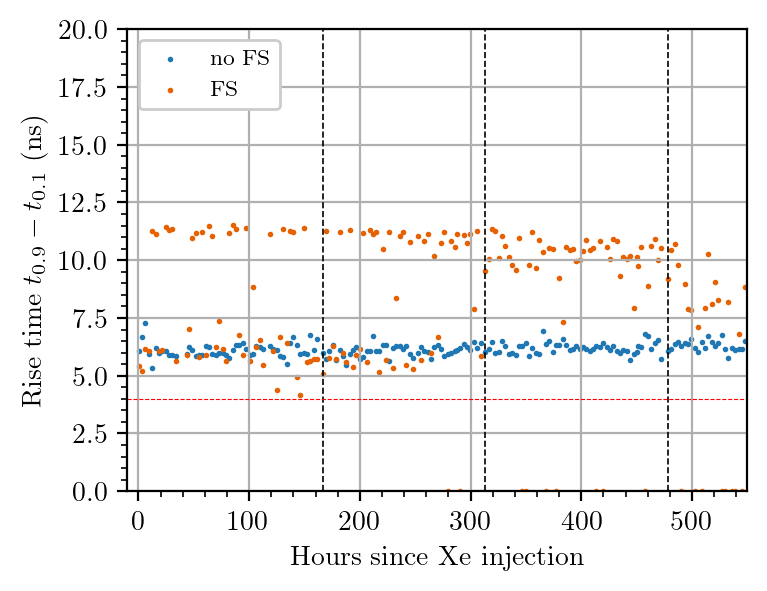

In [ ]:
xlims = (-10,550)
ylims = (0,20)
plt.scatter(hr_from_inject, np.array(t_rise['nofs'])*1e3, label='no FS', s=1)
plt.scatter(hr_from_inject, np.array(t_rise['fs'])*1e3, label='FS', s=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot(xlims,[4]*2,'r--',linewidth=0.4)
plt.ylim(*ylims)
plt.xlim(*xlims)
plt.ylabel(r'Rise time $t_{0.9}-t_{0.1}$ ($\rm ns$)')
plt.xlabel('Hours since Xe injection')
plt.grid()
plt.minorticks_on()
plt.legend()